In [2]:
# Libraries
library(tidyverse)
library(hrbrthemes)
library(circlize)
library(kableExtra)
options(knitr.table.format = "html")
library(viridis)
library(igraph)
library(ggraph)
library(colormap)
library(dplyr)
library(plotly)
library(magrittr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
NOTE: Either Arial Narrow or Roboto Condensed fonts are *required* to use these themes.
      Please use hrbrthemes::import_roboto_condensed() to install Roboto Condensed and
      if Arial Narrow is not on your system, please see http://bit.ly/arialnarrow
circlize version 0.4.4
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: http://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization 
  in R. Bioinformatics 2014.

Loading required package: 

In [2]:
dataUU <- read.table("https://raw.githubusercontent.com/holtzy/data_to_viz/master/Example_dataset/13_AdjacencyUndirectedUnweighted.csv", header=TRUE)
dataUU

from,A.Bateman,A.Besnard,A.Breil,A.Cenci,A.Criscuolo,A.Dassouli,A.Dellagi,A.Dereeper,A.Regnault,⋯,U.Jordan,UK.Hinxton,V.Berry,V.Daubin,V.Dion,V.Lefort,V.Viader,W.Paprotny,Y.Holtz,Y.Moreau
A Armero,NA,NA,1,NA,NA,NA,NA,1,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A Bateman,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,1,NA,NA,NA,NA,NA,NA,NA,1
A Besnard,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,1,NA,NA,NA
A Breil,NA,NA,NA,NA,NA,NA,NA,1,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A Cenci,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A Chifolleau,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,1,NA,NA,NA,NA,NA,NA,NA
A Criscuolo,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A Dassouli,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A Dellagi,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A Dereeper,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Using `nicely` as default layout
Warning message:
“Ignoring unknown parameters: fold”

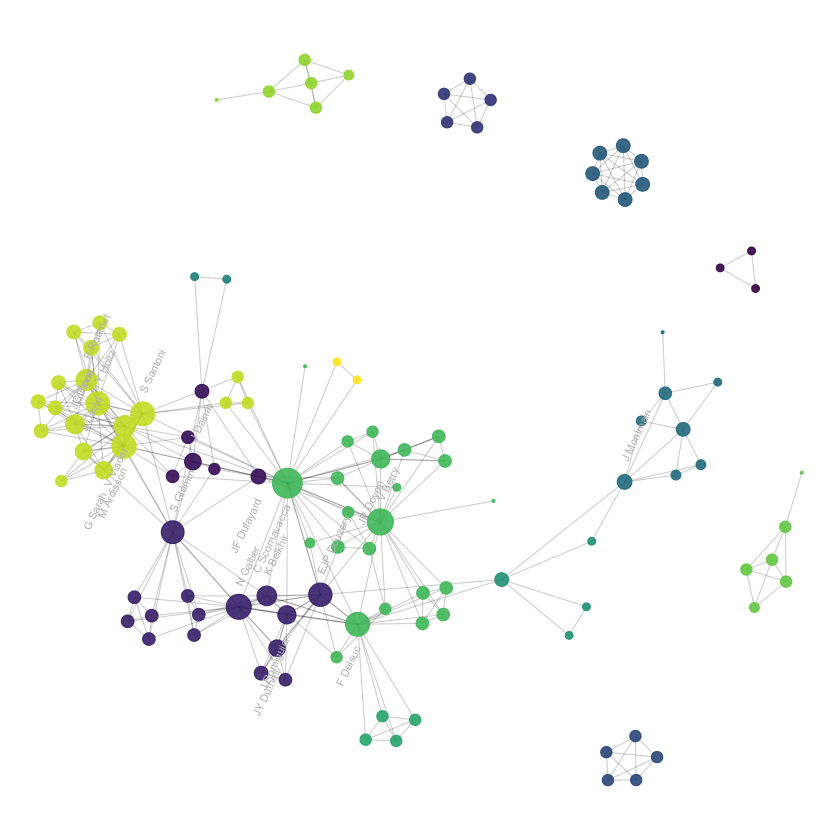

In [3]:
connect <- dataUU %>% 
  gather(key="to", value="value", -1) %>%
  mutate(to = gsub("\\.", " ",to)) %>%
  na.omit() 

# Number of connection per person
c( as.character(connect$from), as.character(connect$to)) %>%
  as.tibble() %>%
  group_by(value) %>%
  summarize(n=n()) -> coauth
colnames(coauth) <- c("name", "n")

# Create a graph object with igraph
mygraph <- graph_from_data_frame( connect, vertices = coauth, directed = FALSE )

# Find community
com <- walktrap.community(mygraph)

#Reorder dataset and make the graph
coauth <- coauth %>% 
  mutate( grp = com$membership) %>%
  arrange(grp) %>%
  mutate(name=factor(name, name))

# keep only 10 first communities
coauth <- coauth %>% 
  filter(grp<16)

# keep only this people in edges
connect <- connect %>%
  filter(from %in% coauth$name) %>%
  filter(to %in% coauth$name)

# Create a graph object with igraph
mygraph <- graph_from_data_frame( connect, vertices = coauth, directed = FALSE )

# prepare a vector of n color in the viridis scale
mycolor <- colormap(colormap=colormaps$viridis, nshades=max(coauth$grp))
mycolor <- sample(mycolor, length(mycolor))

# Make the graph
ggraph(mygraph) + 
  geom_edge_link(edge_colour="black", edge_alpha=0.2, edge_width=0.3, fold=TRUE) +
  geom_node_point(aes(size=n, color=as.factor(grp), fill=grp), alpha=0.9) +
  scale_size_continuous(range=c(0.5,8)) +
  scale_color_manual(values=mycolor) +
  geom_node_text(aes(label=ifelse(n>6, as.character(name), "")), angle=65, hjust=rep(c(0,1),58), nudge_y = rep(c(0.5,-0.5),58), size=2.3, color="grey") +
  theme_void() +
  theme(
    legend.position="none",
    plot.margin=unit(c(0,0,0,0), "null"),
    panel.spacing=unit(c(0,0,0,0), "null")
  ) +
  expand_limits(x = c(-1.2, 1.2), y = c(-1.2, 1.2)) 

In [4]:
# Load researcher data
dataUU <- read.table("https://raw.githubusercontent.com/holtzy/data_to_viz/master/Example_dataset/13_AdjacencyUndirectedUnweighted.csv", header=TRUE)
dataUU

from,A.Bateman,A.Besnard,A.Breil,A.Cenci,A.Criscuolo,A.Dassouli,A.Dellagi,A.Dereeper,A.Regnault,⋯,U.Jordan,UK.Hinxton,V.Berry,V.Daubin,V.Dion,V.Lefort,V.Viader,W.Paprotny,Y.Holtz,Y.Moreau
A Armero,NA,NA,1,NA,NA,NA,NA,1,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A Bateman,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,1,NA,NA,NA,NA,NA,NA,NA,1
A Besnard,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,1,NA,NA,NA
A Breil,NA,NA,NA,NA,NA,NA,NA,1,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A Cenci,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A Chifolleau,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,1,NA,NA,NA,NA,NA,NA,NA
A Criscuolo,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A Dassouli,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A Dellagi,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
A Dereeper,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


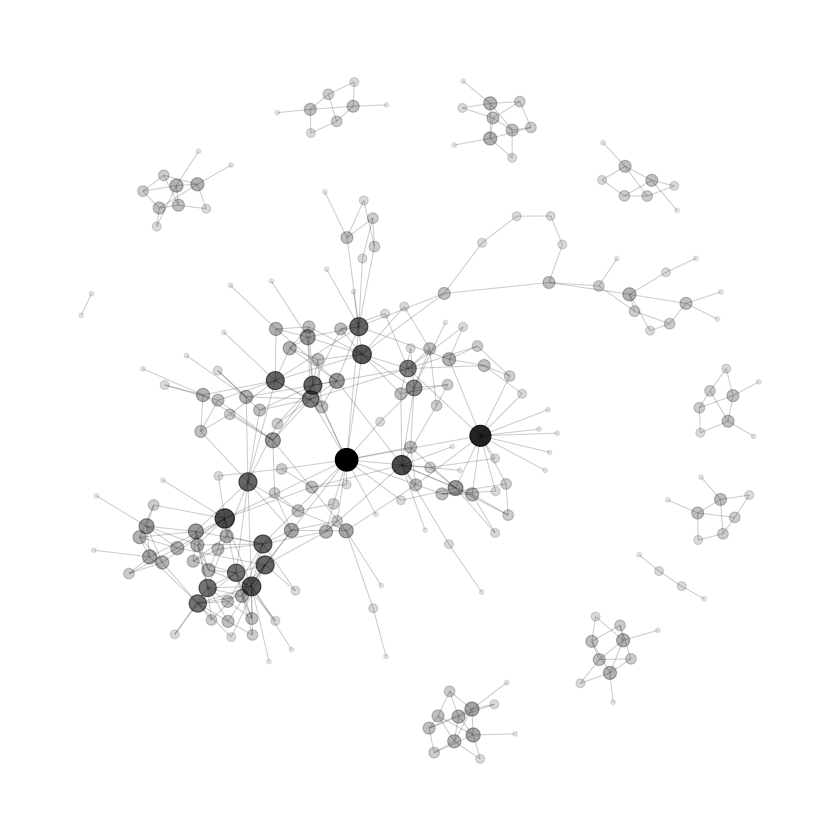

In [3]:

# Transform the adjacency matrix in a long format
connect <- dataUU %>% 
  gather(key="to", value="value", -1) %>%
  na.omit()

# Number of connection per person
c( as.character(connect$from), as.character(connect$to)) %>%
  as.tibble() %>%
  group_by(value) %>%
  summarize(n=n()) -> coauth
colnames(coauth) <- c("name", "n")

# Create a graph object with igraph
mygraph <- graph_from_data_frame( connect, vertices = coauth )

# Make the graph
ggraph(mygraph, layout="fr") + 
  #geom_edge_density(edge_fill="#69b3a2") +
  geom_edge_link(edge_colour="black", edge_alpha=0.2, edge_width=0.3) +
  geom_node_point(aes(size=n, alpha=n)) +
  theme_void() +
  theme(
    legend.position="none",
    plot.margin=unit(rep(1,4), "cm")
  ) 